In [1]:
import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils

import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
import time

%matplotlib inline

/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 16, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'cosine', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 0, 'Number of coarsened graphs.')

flags.DEFINE_string('dir_data', os.path.join('..', 'data', '20news'), 'Directory to store data.')
flags.DEFINE_integer('val_size', 400, 'Size of the validation set.')

In [3]:
##Data preparation

# Fetch dataset. Scikit-learn already performs some cleaning.
remove = ('headers','footers','quotes')  # (), ('headers') or ('headers','footers','quotes')
train = utils.Text20News(data_home=FLAGS.dir_data, subset='train', remove=remove)
print(train)

# Pre-processing: transform everything to a-z and whitespace.
print(train.show_document(1)[:400])
train.clean_text(num='substitute')
print(train)

# Analyzing / tokenizing: transform documents to bags-of-words.
#stop_words = set(sklearn.feature_extraction.text.ENGLISH_STOP_WORDS)
# Or stop words from NLTK.
# Add e.g. don, ve.
train.vectorize(stop_words='english')
print(train.show_document(1)[:400])
print(train)


N = 11314 documents, C = 20 classes
document 1: label 4 --> comp.sys.mac.hardware, 90 words
A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the nex
document 1: label 4 --> comp.sys.mac.hardware, 92 words
  1.00 "adapters" (669)
  2.00 "add" (684)
  1.00 "answered" (2523)
  1.00 "attained" (3941)
  1.00 "base" (5026)
  1.00 "brave" (7179)
  1.00 "brief" (7318)
  1.00 "cards" (8579)
  2.00 "clock" (10473)
  1.00 "cpu" (12728)
  1.00 "day" (14053)
  1.00 "days" (14068)
  1.00 "detailing" (15215)
  1.00 "disk" (16087)
  1.00 "especially" (19550)
  2.00 "experiences" (20279)
  1.00 "fair" (20691)
  1.00 "floppies" (22013)
  1.00 "floppy" (22014)
  1.00

N = 11314 documents, M = 72607 words, sparsity=0.0852%
    480 documents in class  0 (alt.atheism)
    584 documents in class  1 (comp.graphics)
    591 documents in class  2 (comp.os.ms-windows.misc)
    590 documents in class  3 (comp.sys.ibm.pc.hardware)
    578 documents in class  4 (comp.sys.mac.hardware)
    593 documents in class  5 (comp.windows.x)
    585 documents in class  6 (misc.forsale)
    594 documents in class  7 (rec.autos)
    598 documents in class  8 (rec.motorcycles)
    597 documents in class  9 (rec.sport.baseball)
    600 documents in class 10 (rec.sport.hockey)
    595 documents in class 11 (sci.crypt)
    591 documents in class 12 (sci.electronics)
    594 documents in class 13 (sci.med)
    593 documents in class 14 (sci.space)
    599 documents in class 15 (soc.religion.christian)
    546 documents in class 16 (talk.politics.guns)
    564 documents in class 17 (talk.politics.mideast)
    465 documents in class 18 (talk.politics.misc)
    377 documents in cl

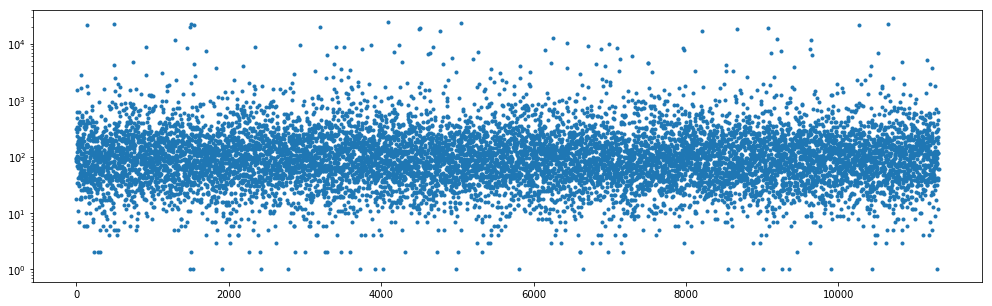

In [4]:
# Remove short documents.
train.data_info(True)
wc = train.remove_short_documents(nwords=20, vocab='full')
train.data_info()
print('shortest: {}, longest: {} words'.format(wc.min(), wc.max()))
plt.figure(figsize=(17,5))
plt.semilogy(wc, '.');

N = 10171 documents, M = 72607 words, sparsity=0.0934%


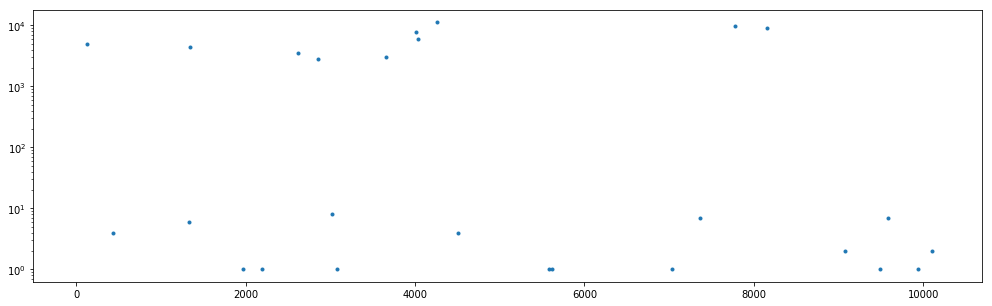

In [5]:
# Remove encoded images.
def remove_encoded_images(dataset, freq=1e3):
    widx = train.vocab.index('ax')
    wc = train.data[:,widx].toarray().squeeze()
    idx = np.argwhere(wc < freq).squeeze()
    dataset.keep_documents(idx)
    return wc
wc = remove_encoded_images(train)
train.data_info()
plt.figure(figsize=(17,5))
plt.semilogy(wc, '.');

In [6]:
# Word embedding
if True:
    train.embed()
else:
    train.embed(os.path.join('..', 'data', 'word2vec', 'GoogleNews-vectors-negative300.bin'))
train.data_info()

53279 words not found in corpus
N = 10171 documents, M = 19328 words, sparsity=0.3141%


most frequent words
    0: num        163934 counts
    1: dollar      10562 counts
    2: people       4093 counts
    3: like         3942 counts
    4: don          3869 counts
    5: just         3721 counts
    6: know         3464 counts
    7: use          3166 counts
    8: think        2995 counts
    9: time         2966 counts
   10: does         2749 counts
   11: new          2606 counts
   12: good         2492 counts
   13: edu          2416 counts
   14: way          2032 counts
   15: make         2022 counts
   16: god          1976 counts
   17: used         1874 counts
   18: ve           1857 counts
   19: say          1841 counts
N = 10171 documents, M = 1000 words, sparsity=2.8353%
document 1: label 4 --> comp.sys.mac.hardware, 92 words
  3.00 "num" (0)
  1.00 "number" (40)
  1.00 "thanks" (48)
  1.00 "day" (76)
  1.00 "send" (97)
  1.00 "disk" (157)
  1.00 "message" (206)
  2.00 "speed" (226)
  1.00 "days" (244)
  1.00 "especially" (383)
  2.00 "add" (443)
  1.0

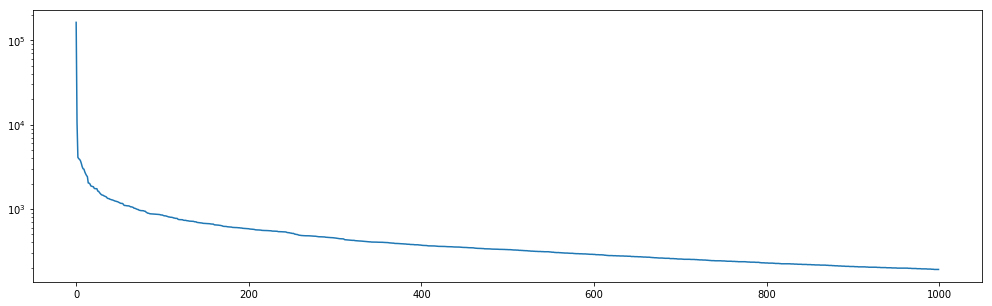

In [7]:
# Feature selection.
# Other options include: mutual information or document count.
freq = train.keep_top_words(1000, 20)
train.data_info()
train.show_document(1)
plt.figure(figsize=(17,5))
plt.semilogy(freq);

# Remove documents whose signal would be the zero vector.
wc = train.remove_short_documents(nwords=5, vocab='selected')
train.data_info(True)

In [8]:
train.normalize(norm='l1')
train.show_document(1);



document 1: label 4 --> comp.sys.mac.hardware, 92 words
  0.13 "num" (0)
  0.04 "number" (40)
  0.04 "thanks" (48)
  0.04 "day" (76)
  0.04 "send" (97)
  0.04 "disk" (157)
  0.04 "message" (206)
  0.09 "speed" (226)
  0.04 "days" (244)
  0.04 "especially" (383)
  0.09 "add" (443)
  0.04 "haven" (467)
  0.04 "network" (529)
  0.04 "cards" (591)
  0.04 "knowledge" (614)
  0.04 "base" (708)
  0.04 "floppy" (758)
  0.09 "clock" (977)


In [9]:
# Test dataset.
test = utils.Text20News(data_home=FLAGS.dir_data, subset='test', remove=remove)
test.clean_text(num='substitute')
test.vectorize(vocabulary=train.vocab)
test.data_info()
wc = test.remove_short_documents(nwords=5, vocab='selected')
print('shortest: {}, longest: {} words'.format(wc.min(), wc.max()))
test.data_info(True)
test.normalize(norm='l1')

N = 7532 documents, C = 20 classes
N = 7532 documents, M = 1000 words, sparsity=2.4662%
shortest: 0, longest: 23751 words
N = 6695 documents, M = 1000 words, sparsity=2.7528%
    275 documents in class  0 (alt.atheism)
    355 documents in class  1 (comp.graphics)
    358 documents in class  2 (comp.os.ms-windows.misc)
    370 documents in class  3 (comp.sys.ibm.pc.hardware)
    348 documents in class  4 (comp.sys.mac.hardware)
    365 documents in class  5 (comp.windows.x)
    359 documents in class  6 (misc.forsale)
    336 documents in class  7 (rec.autos)
    321 documents in class  8 (rec.motorcycles)
    345 documents in class  9 (rec.sport.baseball)
    350 documents in class 10 (rec.sport.hockey)
    344 documents in class 11 (sci.crypt)
    362 documents in class 12 (sci.electronics)
    345 documents in class 13 (sci.med)
    346 documents in class 14 (sci.space)
    365 documents in class 15 (soc.religion.christian)
    319 documents in class 16 (talk.politics.guns)
    338 

In [10]:
if True:
    train_data = train.data.astype(np.float32)
    test_data = test.data.astype(np.float32)
    train_labels = train.labels
    test_labels = test.labels
else:
    perm = np.random.RandomState(seed=42).permutation(dataset.data.shape[0])
    Ntest = 6695
    perm_test = perm[:Ntest]
    perm_train = perm[Ntest:]
    train_data = train.data[perm_train,:].astype(np.float32)
    test_data = train.data[perm_test,:].astype(np.float32)
    train_labels = train.labels[perm_train]
    test_labels = train.labels[perm_test]

if True:
    graph_data = train.embeddings.astype(np.float32)
else:
    graph_data = train.data.T.astype(np.float32).toarray()

In [11]:
###graph
dist, idx = graph.distance_sklearn_metrics(graph_data, k=FLAGS.number_edges, metric=FLAGS.metric)
A = graph.adjacency(dist, idx)
print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*graph_data.shape[0]//2))
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]

11359 > 8000 edges
Layer 0: M_0 = |V| = 1000 nodes (0 added),|E| = 11359 edges


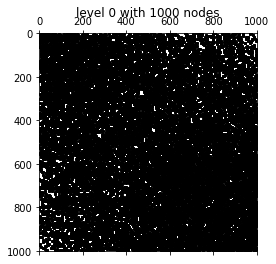

In [12]:
for li in range(len(graphs)):
    plt.figure()
    plt.spy(graphs[li], markersize=2, color='black');
    plt.title('level %d with %d nodes' % (li,graphs[li].shape[0]))

In [13]:
train_data = scipy.sparse.csr_matrix(coarsening.perm_data(train_data.toarray(), perm))
test_data = scipy.sparse.csr_matrix(coarsening.perm_data(test_data.toarray(), perm))

# Validation set.
if False:
    val_data = train_data[:FLAGS.val_size,:]
    val_labels = train_labels[:FLAGS.val_size]
    train_data = train_data[FLAGS.val_size:,:]
    train_labels = train_labels[FLAGS.val_size:]
else:
    val_data = test_data
    val_labels = test_labels

print(train_data.shape,test_data.shape,val_data.shape)
print(np.unique(train_labels))

utils.baseline(train_data, train_labels, test_data, test_labels)

(9922, 1000) (6695, 1000) (6695, 1000)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train accuracy:      46.08 55.27 64.24 98.94 71.39 69.75 73.51
Test accuracy:       28.95 46.90 48.99 49.45 54.80 56.34 57.15
Train F1 (weighted): 46.34 53.35 64.96 98.94 69.93 68.96 72.86
Test F1 (weighted):  28.54 44.72 49.45 48.84 52.50 54.98 56.03
Execution time:       4.20  0.69  0.02  1.33  0.02  0.81  0.74


In [14]:
common = {}
common['dir_name']       = '20news/'
common['num_epochs']     = 80
common['batch_size']     = 100
common['decay_steps']    = len(train_labels) / common['batch_size']
common['eval_frequency'] = 5 * common['num_epochs']
common['filter']         = 'chebyshev5'
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = max(train_labels) + 1  # number of classes


model_perf = utils.model_perf()



In [15]:
##initalize of the model setting
model_perf = utils.model_perf()

###test different param settins
##model1: no convolution
name = 'softmax'
params = common.copy()
params['dir_name'] += name
params['regularization'] = 0
params['dropout']        = 1
params['learning_rate']  = 1e3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['F']              = []
params['K']              = []
params['p']              = []
params['M']              = [C]
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1000
  layer 1: logits (softmax)
    representation: M_1 = 20
    weights: M_0 * M_1 = 1000 * 20 = 20000
    biases: M_1 = 20
step 400 / 7937 (epoch 4.03 / 80):
  learning_rate = 8.15e+02, loss_average = 5.39e+02
  validation accuracy: 20.18 (1351 / 6695), f1 (weighted): 19.83, loss: 3.55e+02
  time: 3s (wall 2s)


/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


step 800 / 7937 (epoch 8.06 / 80):
  learning_rate = 6.63e+02, loss_average = 3.88e+01
  validation accuracy: 49.71 (3328 / 6695), f1 (weighted): 46.51, loss: 5.83e+01
  time: 4s (wall 3s)
step 1200 / 7937 (epoch 12.09 / 80):
  learning_rate = 5.40e+02, loss_average = 2.37e+01
  validation accuracy: 50.81 (3402 / 6695), f1 (weighted): 50.84, loss: 4.54e+01
  time: 6s (wall 5s)
step 1600 / 7937 (epoch 16.13 / 80):
  learning_rate = 4.40e+02, loss_average = 1.74e+01
  validation accuracy: 50.58 (3386 / 6695), f1 (weighted): 52.21, loss: 4.23e+01
  time: 7s (wall 6s)
step 2000 / 7937 (epoch 20.16 / 80):
  learning_rate = 3.58e+02, loss_average = 1.19e+01
  validation accuracy: 53.28 (3567 / 6695), f1 (weighted): 52.38, loss: 3.83e+01
  time: 8s (wall 7s)
step 2400 / 7937 (epoch 24.19 / 80):
  learning_rate = 2.92e+02, loss_average = 1.17e+01
  validation accuracy: 52.41 (3509 / 6695), f1 (weighted): 50.72, loss: 3.70e+01
  time: 9s (wall 8s)
step 2800 / 7937 (epoch 28.22 / 80):
  learning

In [16]:
###model#1: one layer of fully connected  
name = 'fc_softmax'
params = common.copy()
params['dir_name'] += name
params['regularization'] = 0
params['dropout']        = 1
params['learning_rate']  = 0.1
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['F']              = []
params['K']              = []
params['p']              = []
params['M']              = [2500, C]   # Output dimensionality of fully connected layers.
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data, train_labels, val_data, val_labels, test_data, test_labels)



NN architecture
  input: M_0 = 1000
  layer 1: fc1
    representation: M_1 = 2500
    weights: M_0 * M_1 = 1000 * 2500 = 2500000
    biases: M_1 = 2500
  layer 2: logits (softmax)
    representation: M_2 = 20
    weights: M_1 * M_2 = 2500 * 20 = 50000
    biases: M_2 = 20
step 400 / 7937 (epoch 4.03 / 80):
  learning_rate = 8.15e-02, loss_average = 2.13e+00
  validation accuracy: 38.57 (2582 / 6695), f1 (weighted): 37.11, loss: 2.25e+00
  time: 2s (wall 1s)
step 800 / 7937 (epoch 8.06 / 80):
  learning_rate = 6.63e-02, loss_average = 1.64e+00
  validation accuracy: 49.77 (3332 / 6695), f1 (weighted): 48.11, loss: 1.89e+00
  time: 5s (wall 5s)


/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


step 1200 / 7937 (epoch 12.09 / 80):
  learning_rate = 5.40e-02, loss_average = 1.41e+00
  validation accuracy: 51.47 (3446 / 6695), f1 (weighted): 49.11, loss: 1.75e+00
  time: 7s (wall 9s)
step 1600 / 7937 (epoch 16.13 / 80):
  learning_rate = 4.40e-02, loss_average = 1.32e+00
  validation accuracy: 51.84 (3471 / 6695), f1 (weighted): 52.03, loss: 1.66e+00
  time: 9s (wall 12s)
step 2000 / 7937 (epoch 20.16 / 80):
  learning_rate = 3.58e-02, loss_average = 1.20e+00
  validation accuracy: 55.67 (3727 / 6695), f1 (weighted): 54.88, loss: 1.60e+00
  time: 11s (wall 16s)
step 2400 / 7937 (epoch 24.19 / 80):
  learning_rate = 2.92e-02, loss_average = 1.13e+00
  validation accuracy: 55.62 (3724 / 6695), f1 (weighted): 55.11, loss: 1.57e+00
  time: 14s (wall 20s)
step 2800 / 7937 (epoch 28.22 / 80):
  learning_rate = 2.38e-02, loss_average = 1.04e+00
  validation accuracy: 55.58 (3721 / 6695), f1 (weighted): 55.21, loss: 1.56e+00
  time: 16s (wall 24s)
step 3200 / 7937 (epoch 32.25 / 80):
 

In [17]:
##model#2: two layers of fully connected
name = 'fc_fc_softmax'
params = common.copy()
params['dir_name'] += name
params['regularization'] = 0
params['dropout']        = 1
params['learning_rate']  = 0.1
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['F']              = []
params['K']              = []
params['p']              = []
params['M']              = [2500, 500, C] # Output dimensionality of fully connected layers.
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1000
  layer 1: fc1
    representation: M_1 = 2500
    weights: M_0 * M_1 = 1000 * 2500 = 2500000
    biases: M_1 = 2500
  layer 2: fc2
    representation: M_2 = 500
    weights: M_1 * M_2 = 2500 * 500 = 1250000
    biases: M_2 = 500
  layer 3: logits (softmax)
    representation: M_3 = 20
    weights: M_2 * M_3 = 500 * 20 = 10000
    biases: M_3 = 20
step 400 / 7937 (epoch 4.03 / 80):
  learning_rate = 8.15e-02, loss_average = 1.93e+00
  validation accuracy: 27.84 (1864 / 6695), f1 (weighted): 23.72, loss: 2.27e+00
  time: 2s (wall 2s)


/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


step 800 / 7937 (epoch 8.06 / 80):
  learning_rate = 6.63e-02, loss_average = 1.44e+00
  validation accuracy: 49.37 (3305 / 6695), f1 (weighted): 47.08, loss: 1.65e+00
  time: 5s (wall 7s)
step 1200 / 7937 (epoch 12.09 / 80):
  learning_rate = 5.40e-02, loss_average = 1.15e+00
  validation accuracy: 50.60 (3388 / 6695), f1 (weighted): 50.59, loss: 1.63e+00
  time: 8s (wall 12s)
step 1600 / 7937 (epoch 16.13 / 80):
  learning_rate = 4.40e-02, loss_average = 1.03e+00
  validation accuracy: 50.98 (3413 / 6695), f1 (weighted): 50.68, loss: 1.72e+00
  time: 11s (wall 17s)
step 2000 / 7937 (epoch 20.16 / 80):
  learning_rate = 3.58e-02, loss_average = 8.27e-01
  validation accuracy: 54.67 (3660 / 6695), f1 (weighted): 54.59, loss: 1.64e+00
  time: 15s (wall 21s)
step 2400 / 7937 (epoch 24.19 / 80):
  learning_rate = 2.92e-02, loss_average = 6.81e-01
  validation accuracy: 54.86 (3673 / 6695), f1 (weighted): 54.30, loss: 1.70e+00
  time: 18s (wall 26s)
step 2800 / 7937 (epoch 28.22 / 80):
  l

In [18]:
###model#3: one-layer with fourier transform for filter during convolution
name = 'fgconv_softmax'
params = common.copy()
params['dir_name'] += name
params['filter']         = 'fourier'
params['regularization'] = 0
params['dropout']        = 1
params['learning_rate']  = 0.001
params['decay_rate']     = 1
params['momentum']       = 0
params['F']              = [32]             ## Number of graph convolutional filters.
params['K']              = [L[0].shape[0]]  # Polynomial orders.
params['p']              = [1]              # Pooling sizes.
params['M']              = [C]              # Output dimensionality of fully connected layers.
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1000
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1000 * 32 / 1 = 32000
    weights: F_0 * F_1 * K_1 = 1 * 32 * 1000 = 32000
    biases: F_1 = 32
  layer 2: logits (softmax)
    representation: M_2 = 20
    weights: M_1 * M_2 = 32000 * 20 = 640000
    biases: M_2 = 20
step 400 / 7937 (epoch 4.03 / 80):
  learning_rate = 1.00e-03, loss_average = 2.98e+00


/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 5.32 (356 / 6695), f1 (weighted): 1.63, loss: 2.99e+00
  time: 3s (wall 4s)
step 800 / 7937 (epoch 8.06 / 80):
  learning_rate = 1.00e-03, loss_average = 2.99e+00
  validation accuracy: 4.99 (334 / 6695), f1 (weighted): 0.77, loss: 2.99e+00
  time: 6s (wall 9s)
step 1200 / 7937 (epoch 12.09 / 80):
  learning_rate = 1.00e-03, loss_average = 2.99e+00
  validation accuracy: 5.42 (363 / 6695), f1 (weighted): 0.59, loss: 2.99e+00
  time: 8s (wall 14s)
step 1600 / 7937 (epoch 16.13 / 80):
  learning_rate = 1.00e-03, loss_average = 2.99e+00
  validation accuracy: 6.92 (463 / 6695), f1 (weighted): 2.40, loss: 2.99e+00
  time: 11s (wall 19s)
step 2000 / 7937 (epoch 20.16 / 80):
  learning_rate = 1.00e-03, loss_average = 2.99e+00
  validation accuracy: 5.56 (372 / 6695), f1 (weighted): 0.64, loss: 2.99e+00
  time: 14s (wall 24s)
step 2400 / 7937 (epoch 24.19 / 80):
  learning_rate = 1.00e-03, loss_average = 2.99e+00
  validation accuracy: 5.45 (365 / 6695), f1 (weighted): 

In [19]:
###model#4: one-layer convolution with spline basis as filter
name = 'sgconv_softmax'
params = common.copy()
params['dir_name'] += name
params['filter']         = 'spline'
params['regularization'] = 1e-3
params['dropout']        = 1
params['learning_rate']  = 0.1
params['decay_rate']     = 0.999
params['momentum']       = 0
params['F']              = [32]
params['K']              = [5]
params['p']              = [1]
params['M']              = [C]
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1000
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1000 * 32 / 1 = 32000
    weights: F_0 * F_1 * K_1 = 1 * 32 * 5 = 160
    biases: F_1 = 32
  layer 2: logits (softmax)
    representation: M_2 = 20
    weights: M_1 * M_2 = 32000 * 20 = 640000
    biases: M_2 = 20
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database',)).History will not be written to the database.
step 400 / 7937 (epoch 4.03 / 80):
  learning_rate = 9.96e-02, loss_average = 5.28e+00


/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 5.45 (365 / 6695), f1 (weighted): 0.56, loss: 5.28e+00
  time: 3s (wall 4s)
step 800 / 7937 (epoch 8.06 / 80):
  learning_rate = 9.92e-02, loss_average = 5.10e+00
  validation accuracy: 5.45 (365 / 6695), f1 (weighted): 0.56, loss: 5.10e+00
  time: 6s (wall 9s)
step 1200 / 7937 (epoch 12.09 / 80):
  learning_rate = 9.88e-02, loss_average = 4.94e+00
  validation accuracy: 5.45 (365 / 6695), f1 (weighted): 0.56, loss: 4.94e+00
  time: 9s (wall 14s)
step 1600 / 7937 (epoch 16.13 / 80):
  learning_rate = 9.84e-02, loss_average = 4.79e+00
  validation accuracy: 5.45 (365 / 6695), f1 (weighted): 0.56, loss: 4.79e+00
  time: 12s (wall 20s)
step 2000 / 7937 (epoch 20.16 / 80):
  learning_rate = 9.80e-02, loss_average = 4.66e+00
  validation accuracy: 5.45 (365 / 6695), f1 (weighted): 0.56, loss: 4.66e+00
  time: 15s (wall 25s)
step 2400 / 7937 (epoch 24.19 / 80):
  learning_rate = 9.76e-02, loss_average = 4.53e+00
  validation accuracy: 5.45 (365 / 6695), f1 (weighted): 

In [20]:
##model#4: one-layer convolution with chebyshev5 and b1relu as filters
name = 'cgconv_softmax'
params = common.copy()
params['dir_name'] += name
params['regularization'] = 1e-3
params['dropout']        = 1
params['learning_rate']  = 0.1
params['decay_rate']     = 0.999
params['momentum']       = 0
params['F']              = [32]
params['K']              = [5]
params['p']              = [1]
params['M']              = [C]
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1000
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1000 * 32 / 1 = 32000
    weights: F_0 * F_1 * K_1 = 1 * 32 * 5 = 160
    biases: F_1 = 32
  layer 2: logits (softmax)
    representation: M_2 = 20
    weights: M_1 * M_2 = 32000 * 20 = 640000
    biases: M_2 = 20
step 400 / 7937 (epoch 4.03 / 80):
  learning_rate = 9.96e-02, loss_average = 5.28e+00


/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 5.63 (377 / 6695), f1 (weighted): 0.92, loss: 5.28e+00
  time: 3s (wall 2s)
step 800 / 7937 (epoch 8.06 / 80):
  learning_rate = 9.92e-02, loss_average = 5.10e+00
  validation accuracy: 8.33 (558 / 6695), f1 (weighted): 3.29, loss: 5.10e+00
  time: 5s (wall 5s)
step 1200 / 7937 (epoch 12.09 / 80):
  learning_rate = 9.88e-02, loss_average = 4.93e+00
  validation accuracy: 8.68 (581 / 6695), f1 (weighted): 3.60, loss: 4.93e+00
  time: 8s (wall 8s)
step 1600 / 7937 (epoch 16.13 / 80):
  learning_rate = 9.84e-02, loss_average = 4.74e+00
  validation accuracy: 10.11 (677 / 6695), f1 (weighted): 4.83, loss: 4.75e+00
  time: 11s (wall 11s)
step 2000 / 7937 (epoch 20.16 / 80):
  learning_rate = 9.80e-02, loss_average = 4.56e+00
  validation accuracy: 13.94 (933 / 6695), f1 (weighted): 10.28, loss: 4.56e+00
  time: 13s (wall 13s)
step 2400 / 7937 (epoch 24.19 / 80):
  learning_rate = 9.76e-02, loss_average = 4.36e+00
  validation accuracy: 17.45 (1168 / 6695), f1 (weighte

In [21]:
name = 'cgconv_fc_softmax'
params = common.copy()
params['dir_name'] += name
params['regularization'] = 0
params['dropout']        = 1
params['learning_rate']  = 0.1
params['decay_rate']     = 0.999
params['momentum']       = 0
params['F']              = [5]
params['K']              = [15]
params['p']              = [1]
params['M']              = [100, C]
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1000
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1000 * 5 / 1 = 5000
    weights: F_0 * F_1 * K_1 = 1 * 5 * 15 = 75
    biases: F_1 = 5
  layer 2: fc1
    representation: M_2 = 100
    weights: M_1 * M_2 = 5000 * 100 = 500000
    biases: M_2 = 100
  layer 3: logits (softmax)
    representation: M_3 = 20
    weights: M_2 * M_3 = 100 * 20 = 2000
    biases: M_3 = 20
step 400 / 7937 (epoch 4.03 / 80):
  learning_rate = 9.96e-02, loss_average = 2.98e+00


/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 6.14 (411 / 6695), f1 (weighted): 1.46, loss: 2.99e+00
  time: 3s (wall 3s)
step 800 / 7937 (epoch 8.06 / 80):
  learning_rate = 9.92e-02, loss_average = 2.95e+00
  validation accuracy: 9.92 (664 / 6695), f1 (weighted): 4.45, loss: 2.95e+00
  time: 7s (wall 7s)
step 1200 / 7937 (epoch 12.09 / 80):
  learning_rate = 9.88e-02, loss_average = 2.87e+00
  validation accuracy: 10.65 (713 / 6695), f1 (weighted): 6.05, loss: 2.88e+00
  time: 10s (wall 10s)
step 1600 / 7937 (epoch 16.13 / 80):
  learning_rate = 9.84e-02, loss_average = 2.80e+00
  validation accuracy: 15.59 (1044 / 6695), f1 (weighted): 12.23, loss: 2.80e+00
  time: 13s (wall 14s)
step 2000 / 7937 (epoch 20.16 / 80):
  learning_rate = 9.80e-02, loss_average = 2.52e+00
  validation accuracy: 28.95 (1938 / 6695), f1 (weighted): 27.35, loss: 2.58e+00
  time: 17s (wall 18s)
step 2400 / 7937 (epoch 24.19 / 80):
  learning_rate = 9.76e-02, loss_average = 2.00e+00
  validation accuracy: 39.55 (2648 / 6695), f1 (w

  accuracy        F1             loss        time [ms]  name
test  train   test  train   test     train
51.59 94.36   52.05 94.58   2.72e+00 2.71e-01     9   cgconv_fc_softmax
55.83 79.00   55.55 78.83   2.35e+00 1.57e+00     7   cgconv_softmax
56.80 93.48   56.62 93.46   1.85e+00 3.14e-01    12   fc_fc_softmax
57.40 75.53   56.95 75.14   1.50e+00 9.43e-01     9   fc_softmax
 5.45  5.63    0.56  0.60   2.99e+00 3.01e+00    13   fgconv_softmax
 6.62  6.83    1.49  1.50   3.53e+00 3.55e+00    13   sgconv_softmax
54.92 88.01   54.87 87.98   2.88e+01 2.42e+00     3   softmax
grid search: 1 combinations to evaluate


  {}  


NN architecture
  input: M_0 = 1000
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1000 * 5 / 1 = 5000
    weights: F_0 * F_1 * K_1 = 1 * 5 * 15 = 75
    biases: F_1 = 5
  layer 2: fc1
    representation: M_2 = 100
    weights: M_1 * M_2 = 5000 * 100 = 500000
    biases: M_2 = 100
  layer 3: logits (softmax)
    representation: M_3 = 20
    weights: M_2 * M_3

/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 7.05 (472 / 6695), f1 (weighted): 1.61, loss: 2.99e+00
  time: 4s (wall 4s)
step 800 / 7937 (epoch 8.06 / 80):
  learning_rate = 9.92e-02, loss_average = 2.94e+00
  validation accuracy: 9.34 (625 / 6695), f1 (weighted): 3.66, loss: 2.95e+00
  time: 7s (wall 7s)
step 1200 / 7937 (epoch 12.09 / 80):
  learning_rate = 9.88e-02, loss_average = 2.88e+00
  validation accuracy: 10.71 (717 / 6695), f1 (weighted): 5.47, loss: 2.89e+00
  time: 11s (wall 11s)
step 1600 / 7937 (epoch 16.13 / 80):
  learning_rate = 9.84e-02, loss_average = 2.81e+00
  validation accuracy: 14.64 (980 / 6695), f1 (weighted): 10.74, loss: 2.83e+00
  time: 14s (wall 15s)
step 2000 / 7937 (epoch 20.16 / 80):
  learning_rate = 9.80e-02, loss_average = 2.62e+00
  validation accuracy: 20.63 (1381 / 6695), f1 (weighted): 17.77, loss: 2.69e+00
  time: 18s (wall 18s)
step 2400 / 7937 (epoch 24.19 / 80):
  learning_rate = 9.76e-02, loss_average = 2.22e+00
  validation accuracy: 29.84 (1998 / 6695), f1 (we

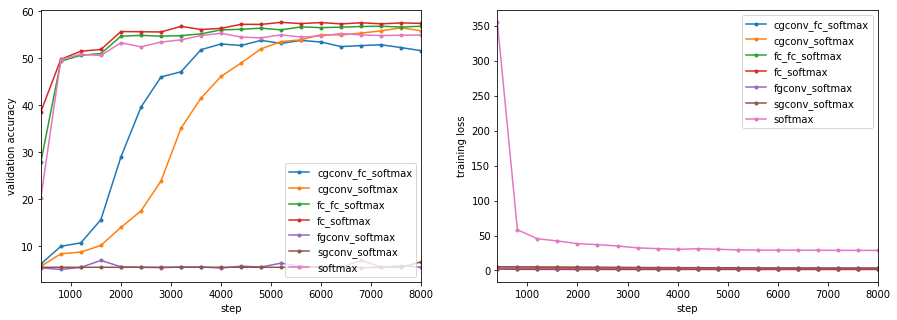

In [22]:
model_perf.show()

grid_params = {}
data = (train_data, train_labels, val_data, val_labels, test_data, test_labels)
utils.grid_search(params, grid_params, *data, model=lambda x: models.cgcnn(L,**x))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0. 12.]
 [ 0.  0.  0. ...  0. 12.  0.]]
[ 7  5 17 ...  9  6 15]


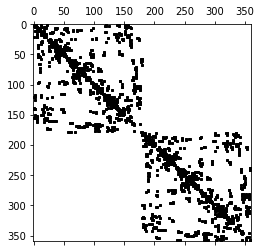

In [26]:
import nibabel as nib
adj_mat = '/mnt/home_sq/yzhang/PycharmProjects/MMP_adjacency_mat.pconn.nii'
mmp_atlas_roi = nib.load(adj_mat).get_data()
print(mmp_atlas_roi)

plt.spy(mmp_atlas_roi, markersize=2, color='black');
print(test_labels)